In [11]:
import cv2
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

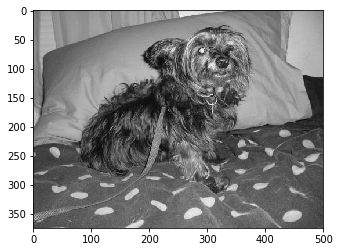

In [12]:
DATADIR = "C:/Users/Zander Luke/Documents\Data Science/Cat and Dog Image Dataset"



CATEGORIES = ['Dog', 'Cat']

# iterate through dogs and cats categories
for category in CATEGORIES:
    path = os.path.join(DATADIR, category) # creates a path to dogs and cats
    for img in os.listdir(path): # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path, img) , cv2.IMREAD_GRAYSCALE) # convert to array
        plt.imshow(img_array, cmap='gray') # graph the image
        plt.show()
        
        break # only plot one image for now
    break #break the iteration loop

Let's inspect the image array visually and verify its shape

In [13]:
print(img_array)

[[117 117 119 ... 133 132 132]
 [118 117 119 ... 135 134 134]
 [119 118 120 ... 137 136 136]
 ...
 [ 79  74  73 ...  80  76  73]
 [ 78  72  69 ...  72  73  74]
 [ 74  71  70 ...  75  73  71]]


In [14]:
print(img_array.shape)

(375, 500)


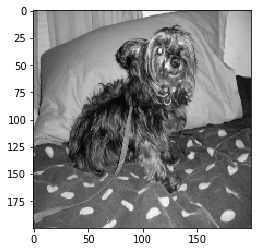

In [15]:
IMG_SIZE = 200

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # create a new array from a resized image
plt.imshow(new_array, cmap='gray') # plot the image
plt.show()

Now let's build our training data

In [16]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        
        path = os.path.join(DATADIR,category) # create a path to dogs and cats folders and then creat paths from each subfolder in the folder
        class_num = CATEGORIES.index(category) # retrieve the classificaiton. 0=dog 1=cat
        
        for img in tqdm(os.listdir(path)): # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE) # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # normalize the data size by resizing the images all to one size
                training_data.append([new_array, class_num]) # add this list to our training_data
            except Exception as e: # keeps the output clean by ignoring minor exceptions
                pass
                
                
create_training_data()
print(len(training_data))

100%|██████████| 12501/12501 [00:15<00:00, 786.26it/s]


24946


Looks like we have almost 25,000 training examples

Since we iterated through each folder in order our dataset currently is in order. This means that one porttion of the data is all dog images and the other portion is cat images. This will throw off our model if we try to use the data as is becuase the model will start learning the and quickly relize that the set is all dogs so it will only predict dogs. Then, when we get to the cats portion of the data the model will realize that it is continuously wrong because it is voting all dogs on cat images which will then make it memorize and vote only cate images. 

We have to shuffle the examples to avoid this data bias. Since our training_data is a list it is easily mutable so we can easily shuffle the samples.

Below we'll shuffle the data and then iterate through a few examples to verify that the data shuffled correctly

In [17]:
import random

random.shuffle(training_data)

In [18]:
for sample in training_data[:10]: # iterate through and print the first 10 examples
    print(sample[1]) # we splice through the second column (index value 1) because our 1st column is the array of data for each image and the second column is our labels

1
0
0
1
1
1
1
0
0
1


Classes look properly shuffled

Now we'll creat our model

In [19]:
X = []
y = []

for features, label in training_data: #iterate through training data
    X.append(features) # append features to X variable
    y.append(label) # append labels to y variable

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # reshape X array to our single image size. The -1 value tells the reshape function to create a one shape dimension array

[[[[ 52]
   [ 51]
   [ 50]
   ...
   [ 82]
   [ 83]
   [ 83]]

  [[ 52]
   [ 51]
   [ 51]
   ...
   [ 84]
   [ 85]
   [ 85]]

  [[ 53]
   [ 51]
   [ 51]
   ...
   [ 86]
   [ 87]
   [ 87]]

  ...

  [[ 24]
   [ 24]
   [ 25]
   ...
   [174]
   [139]
   [105]]

  [[ 19]
   [ 20]
   [ 21]
   ...
   [194]
   [162]
   [121]]

  [[ 15]
   [ 17]
   [ 19]
   ...
   [203]
   [179]
   [138]]]]


Let's pickle the data so it is saved off and we don't have to load it each time we call on the model

In [20]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

We can load this data into our current script or a completely new one with the following code

In [21]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

Now we can build our model

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import TensorBoard
import time

In [ ]:
NAME = "Cats-vs-dogs-CNN-64x2-{}".format(int(time.time()))


pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)


X = X/255.0

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'],
             )

model.fit(X, y,
         batch_size=32,
         epochs=10,
         validation_split=0.3,
         callbacks=[tensorboard])

Instructions for updating:
Colocations handled automatically by placer.
Train on 17462 samples, validate on 7484 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
